In [12]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

## 1. Build the model

In [ ]:
class Model(object):
    def __init__(self):
        self.W = tf.Variable(5.0)
        self.b = tf.Variable(0.0)

    def __call__(self, x):
        return self.W * x + self.b
model = Model()

## 2. Prepare training Data

In [ ]:
True_w = 3.0
True_b = 2.0
NUM_EX = 1000
xs = tf.random.normal(shape=[NUM_EX])
ys = True_w * xs + True_b

In [ ]:
def plot_data(xs, ys, y_pred):
    real = plt.scatter(xs, ys, c='b')
    pred = plt.scatter(xs, y_pred, c='r')
    plt.legend((real, pred), ('real data', 'pred data'))
    plt.show()

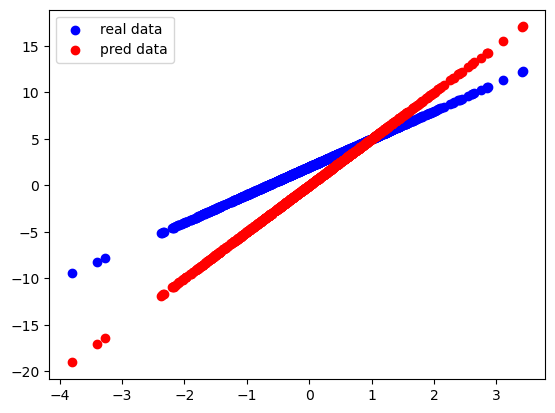

In [ ]:
plot_data(xs, ys, model(xs))

## 3. Mean Squared Error Loss

In [ ]:
def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

## 4. Calculate Partial Derivative of Loss

In [ ]:
def train(model, xs, ys, lr=0.1):
    with tf.GradientTape(persistent=True) as tape:
        y_pred = model(xs)
        loss = mse(ys, y_pred)
    w_grad = tape.gradient(loss, model.W)
    b_grad = tape.gradient(loss, model.b)
    model.W.assign_sub(lr * w_grad)
    model.b.assign_sub(lr * b_grad)

    return loss

## 5. Define Training Loop

In [ ]:
epochs = range(20)
w = []
b = []
losses = []
for epoch in epochs:
    current_loss = train(model, xs, ys, lr=0.1)
    w.append(model.W.numpy())
    b.append(model.b.numpy())
    losses.append(current_loss)
    print(f'epoch {epoch}: w={w[-1]}, b={b[-1]}, loss={current_loss}')



epoch 0: w=4.594470024108887, b=0.38477882742881775, loss=7.903087615966797
epoch 1: w=4.27132511138916, b=0.6956881880760193, loss=5.087160110473633
epoch 2: w=4.013795852661133, b=0.9468749761581421, loss=3.275146007537842
epoch 3: w=3.808532953262329, b=1.1497844457626343, loss=2.1089184284210205
epoch 4: w=3.6449079513549805, b=1.3136740922927856, loss=1.358188509941101
epoch 5: w=3.514458417892456, b=1.4460312128067017, loss=0.8748399615287781
epoch 6: w=3.410444974899292, b=1.5529096126556396, loss=0.5635895133018494
epoch 7: w=3.327500104904175, b=1.6392040252685547, loss=0.3631286025047302
epoch 8: w=3.261348009109497, b=1.708870768547058, loss=0.2340015321969986
epoch 9: w=3.2085824012756348, b=1.7651076316833496, loss=0.1508117914199829
epoch 10: w=3.166489362716675, b=1.8104987144470215, loss=0.09720930457115173
epoch 11: w=3.132906198501587, b=1.8471318483352661, loss=0.06266628950834274
epoch 12: w=3.106109380722046, b=1.8766939640045166, loss=0.0404028594493866
epoch 13: 

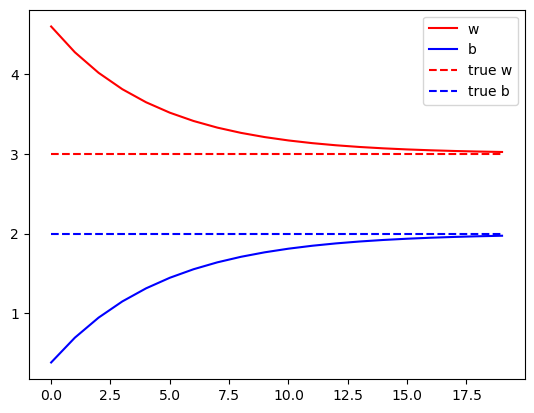

In [ ]:
plt.plot(epochs, w, 'r')
plt.plot(epochs, b, 'b')
plt.plot([True_w] * len(epochs), 'r--')
plt.plot([True_b] * len(epochs), 'b--')
plt.legend(['w', 'b', 'true w', 'true b'])

## 6.Validate the Model

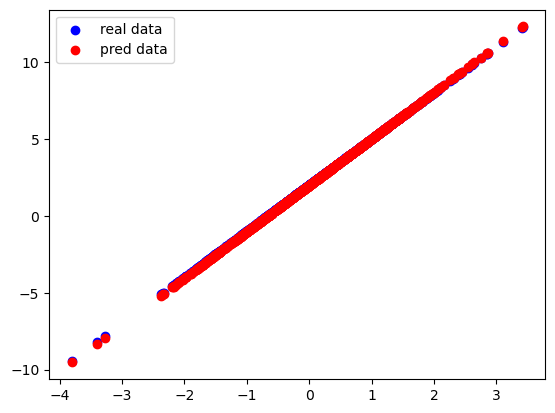

In [ ]:
y_pred = model(xs)
plot_data(xs, ys, y_pred)

# Fashion MNIST

In [15]:
import tensorflow as tf
from tqdm import tqdm
import tensorflow_datasets as tfds


ModuleNotFoundError: No module named 'tqdm'

In [3]:
train_data = tfds.load("fashion_mnist", split="train")
test_data = tfds.load("fashion_mnist", split="test")

In [26]:
def format_image(data):
  image = data['image']
  image = tf.reshape(image, [-1])
  image = tf.cast(image, dtype='float32')
  image = image / 255.0
  return image, data['label']

train_data = train_data.map(format_image)
test_data = test_data.map(format_image)
batch_size = 64
train = train_data.shuffle(buffer_size=1024).batch(batch_size)
test = test_data.batch(batch_size)

In [3]:
def base_model():
  input = tf.keras.layers.Input(shape=(784,), name="input")
  x = tf.keras.layers.Dense(64, activation='relu', name="dense_1")(input)
  x = tf.keras.layers.Dense(64, activation='relu', name="dense_2")(x)
  outputs = tf.keras.layers.Dense(10, activation="softmax", name="outputs")(x)
  return tf.keras.Model(input, outputs)

In [10]:
model = base_model()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [11]:
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

In [12]:
def apply_gradient(loss_object, optimizer, model, x, y):
    with tf.GradientTape() as tape:
        logits = model(x)
        loss  = loss_object(y_true=y, y_pred=logits)
    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradient(zip(gradients, model.trainable_weights))
    
    return logits, loss

In [5]:
def perform_validation(test_dataset):
    losses = []
    
    for x_val, y_val in test_dataset:
        val_logits = model(x_val)
        loss = loss_object(y_true=y_val, y_pred=val_logits)
        losses.append(loss)
    return losses

In [7]:
def train_data_one_epoch(train_dataset):
    losses = []
    pbar = tqdm(total=len(list(enumerate(train_dataset))), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        logits, loss_value = apply_gradient(loss_object=loss_object, 
                                            optimizer=optimizer, 
                                            model=model,
                                            x=x_batch_train,
                                            y=y_batch_train)
        losses.append(loss_value)
    return losses

In [8]:
epochs = 20
for epoch in range(epochs):
    losses_train = train_data_one_epoch(train)
    losses_val = perform_validation(test)
    

NameError: name 'train' is not defined